## IMPORTING THE REQUIRED LIBRARIES

In [47]:
#Make sure all the following libraries are installed before running the application. 
import pandas as pd
import numpy as np
import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings

from keras.preprocessing import sequence
from keras import optimizers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, SimpleRNN, BatchNormalization
from keras.models import model_from_json

warnings.filterwarnings("ignore")
%matplotlib inline



## LOADING TRAINING AND TESTING DATA

In [48]:
#memasukan tabel dalam file .csv sebagai header di training data

#load the csv file containing the column names 
column_name = pd.read_csv("Field Names.csv", header = None)

In [49]:
#mengubah baris yg ada di file .csv sebagai msg2 kolom baru

#Convert the array into list
new_columns = list(column_name[0].values)

In [50]:
#menambah kolom kelas dan kesulitan

#adding difficulty 
new_columns += ['class', 'difficulty']

In [51]:
#loading train and test data files
train_data = pd.read_csv('KDDTrain+.txt', names = new_columns)
test_data = pd.read_csv('KDDTest+.txt', names = new_columns)

In [52]:
#Training data sample
print("The training data is")
train_data.tail()

The training data is


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.0,1.00,1.0,0.00,0.0,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.0,0.00,0.0,0.00,0.0,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.0,0.72,0.0,0.01,0.0,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.0,1.00,1.0,0.00,0.0,neptune,20
125972,0,tcp,ftp_data,SF,151,0,0,0,0,0,...,0.30,0.03,0.30,0.0,0.00,0.0,0.00,0.0,normal,21


In [53]:
#Output total rows and columns of dataframe
print(f"The shape of the training dataframe is : {train_data.shape}")

The shape of the training dataframe is : (125973, 43)


In [54]:
#Same for testing
print("The testing data is")
test_data.head()

The testing data is


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [55]:
#Idem dito ^
print(f"The shape of the testing dataframe is : {test_data.shape}")

The shape of the testing dataframe is : (22544, 43)


In [56]:
#Load attacks.txt containing the attack categories
map_attacks = [x.strip().split() for x in open('attacks.txt', 'r')]
map_attacks = {k:v for (k,v) in map_attacks}

In [57]:
#Replace the "class" column values to 5 attack categories in training and testing dataframe
train_data['class'] = train_data['class'].replace(map_attacks)
test_data['class'] = test_data['class'].replace(map_attacks)

In [58]:
train_data = shuffle(train_data)

## DATA PREPROCESSING

In [59]:
#separate the training dataframe into feature columns and label columns
X = train_data.drop('class', axis = 1) #Independent features
y = train_data['class'] #Dependent features (Labels)

In [60]:
#Converting String to Integer with get_dummies by pandas
columns = ['protocol_type', 'service', 'flag']
X_new = pd.get_dummies(X, columns = columns, drop_first = True)

In [61]:
#Idem dito for class ^
y_new = train_data['class']
y_new = pd.get_dummies(y_new)

In [62]:
#Split data: 80% training and 20% testing 
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.2, random_state = 101)

In [63]:
#Use StandardScaler() to standardize data - explained in Honours Project
sc = StandardScaler()
sc.fit(np.array(X_train))
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [64]:
#untuk melihat data yang digunakan

#Training data sample
print("The training data is")
print (X_train)
print (y_train)
print("--------------------------------------------------------------------------------")
#Output total rows and columns of dataframe
print(f"The shape of the training X_train dataframe is : {X_train.shape}")
print(f"The shape of the training y_train dataframe is : {y_train.shape}")
print("--------------------------------------------------------------------------------")

#Same for testing
print("The testing data is")
print (X_test)
print (y_test)
print("--------------------------------------------------------------------------------")
#Idem dito ^
print(f"The shape of the testing X_test dataframe is : {X_test.shape}")
print(f"The shape of the testing y_test dataframe is : {y_test.shape}")

The training data is
[[-0.11086349 -0.0079693  -0.00466275 ... -0.01916451 -1.21350498
  -0.04677384]
 [-0.11086349 -0.0079693  -0.00466275 ... -0.01916451 -1.21350498
  -0.04677384]
 [-0.11086349 -0.00780667 -0.00466275 ... -0.01916451  0.82405925
  -0.04677384]
 ...
 [-0.11086349 -0.0079073  -0.00456056 ... -0.01916451  0.82405925
  -0.04677384]
 [-0.11086349 -0.00796783 -0.00466275 ... -0.01916451  0.82405925
  -0.04677384]
 [-0.11086349 -0.0079693  -0.00466275 ... -0.01916451 -1.21350498
  -0.04677384]]
        dos  normal  probe  r2l  u2r
45149     1       0      0    0    0
99985     1       0      0    0    0
104151    0       1      0    0    0
121245    0       1      0    0    0
63066     1       0      0    0    0
...     ...     ...    ...  ...  ...
118736    0       1      0    0    0
84120     0       1      0    0    0
15346     0       1      0    0    0
2539      0       0      1    0    0
34247     1       0      0    0    0

[100778 rows x 5 columns]
----------------

MODEL 1: 

First model. This model contains all the dense layers. In dense layers each node or neuron in a layer is connected to all the nodes/neurons in the preceding layer, further explained in Honours Document. 

In [65]:
#Use the keras's sequential API 
#First dense layer takes an input parameter as 256 (number of neurons in the first layer).
#The second parameter "input_dim" corresponds to the input features. 
#Use "relu" as activation function.
#The activation function for last dense layer is "softmax" because of the multiple classes, further explained in document.
#Set dropout for 10%. 
model1 = Sequential()
model1.add(Dense(64, input_dim = 120, activation = "relu", kernel_initializer = "lecun_normal"))
model1.add(Dense(128, activation = "relu"))
model1.add(Dense(5, activation = "softmax"))

In [66]:
#Summary of model architecture listing information about parameters per layer. 
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                7744      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 645       
Total params: 16,709
Trainable params: 16,709
Non-trainable params: 0
_________________________________________________________________


In [67]:
#Three paramaters: 
#Loss - The loss function.
#Optimizer - To minimize the loss function.
#Metrics - The mode of evaluation for our model.
#"categorical_loss" - is used because of the multi-class classifcation problem.
#"adam" - The updated version of SGD.
optim = optimizers.SGD(lr = 0.0001)
model1.compile(loss = 'categorical_crossentropy', optimizer = optim, metrics = ['accuracy'])

In [68]:
#Fit the model on our data.
#X_train - The feature columns of the training data.
#y_train - The labels columns of the training data.
#validation_data - The validation data
#batch_size and epochs further explained in document. 
history = model1.fit(X_train, y_train, 
          validation_data = (X_test, y_test),
          batch_size = 32, 
          epochs = 20)

Train on 100778 samples, validate on 25195 samples
Epoch 1/20
100778/100778 [==============================] - 8s 77us/step - loss: 1.2360 - accuracy: 0.6584 - val_loss: 0.9682 - val_accuracy: 0.7752
Epoch 2/20
100778/100778 [==============================] - 8s 76us/step - loss: 0.8031 - accuracy: 0.8340 - val_loss: 0.6675 - val_accuracy: 0.8681
Epoch 3/20
100778/100778 [==============================] - 8s 76us/step - loss: 0.5738 - accuracy: 0.8752 - val_loss: 0.4989 - val_accuracy: 0.8814
Epoch 4/20
100778/100778 [==============================] - 8s 77us/step - loss: 0.4441 - accuracy: 0.8880 - val_loss: 0.4007 - val_accuracy: 0.8987
Epoch 5/20
100778/100778 [==============================] - 8s 80us/step - loss: 0.3651 - accuracy: 0.9158 - val_loss: 0.3376 - val_accuracy: 0.9303
Epoch 6/20
100778/100778 [==============================] - 8s 78us/step - loss: 0.3122 - accuracy: 0.9369 - val_loss: 0.2935 - val_accuracy: 0.9429
Epoch 7/20
100778/100778 [=============================

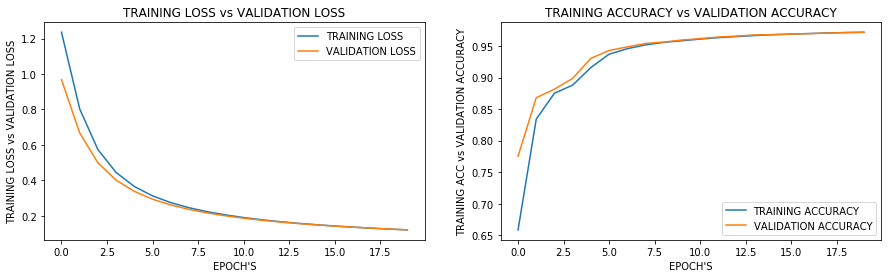

In [69]:
#use matplitlib to draw the plots
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = "TRAINING LOSS")
plt.plot(history.history['val_loss'], label = "VALIDATION LOSS")
plt.title("TRAINING LOSS vs VALIDATION LOSS")
plt.xlabel("EPOCH'S")
plt.ylabel("TRAINING LOSS vs VALIDATION LOSS")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = "TRAINING ACCURACY")
plt.plot(history.history['val_accuracy'], label = "VALIDATION ACCURACY")
plt.title("TRAINING ACCURACY vs VALIDATION ACCURACY")
plt.xlabel("EPOCH'S")
plt.ylabel("TRAINING ACC vs VALIDATION ACCURACY")
plt.legend(loc = "best")

Explained in Results section.

Load and save model 1:

In [70]:
#Serialize model 1 , save with json. 
model_json = model1.to_json() 
with open("model1.json", "w") as json_file:
    json_file.write(model_json)
model1.save_weights('model1_weights.h5')
print("Saved model to disk")

Saved model to disk


In [71]:
# load model 1. 
json_file = open("model1.json", "r") 
loaded_model_json = json_file.read() 
json_file.close() 
loaded_model = model_from_json(loaded_model_json) 
loaded_model.load_weights("model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


Model 2: 

Single Dense Hidden Layer with Output Layer

In [72]:
model2 = Sequential()
model2.add(Dense(32, input_dim = 120, activation = "relu", kernel_initializer = "lecun_normal"))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(32, activation = "relu"))
model2.add(Dense(5, activation = "softmax"))

In [73]:
#List summary again 
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                3872      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 165       
Total params: 5,221
Trainable params: 5,157
Non-trainable params: 64
_________________________________________________________________


In [74]:
#SGD used instead of Adam!
optim2 = optimizers.Adam(lr = 0.0001)
model2.compile(loss = 'categorical_crossentropy', optimizer = optim, metrics = ['accuracy'])

In [75]:
#Train model and validate. 
history2 = model2.fit(X_train, y_train, 
           batch_size = 32, 
           epochs = 30, 
           validation_data = (X_test, y_test))

Train on 100778 samples, validate on 25195 samples
Epoch 1/30
100778/100778 [==============================] - 10s 99us/step - loss: 0.9216 - accuracy: 0.7588 - val_loss: 0.7884 - val_accuracy: 0.8401
Epoch 2/30
100778/100778 [==============================] - 9s 92us/step - loss: 0.6223 - accuracy: 0.8370 - val_loss: 0.5478 - val_accuracy: 0.8760
Epoch 3/30
100778/100778 [==============================] - 9s 92us/step - loss: 0.4801 - accuracy: 0.8743 - val_loss: 0.4451 - val_accuracy: 0.9213
Epoch 4/30
100778/100778 [==============================] - 9s 92us/step - loss: 0.3957 - accuracy: 0.8999 - val_loss: 0.3857 - val_accuracy: 0.9361
Epoch 5/30
100778/100778 [==============================] - 10s 98us/step - loss: 0.3372 - accuracy: 0.9173 - val_loss: 0.2976 - val_accuracy: 0.9472
Epoch 6/30
100778/100778 [==============================] - 10s 96us/step - loss: 0.2972 - accuracy: 0.9278 - val_loss: 0.2832 - val_accuracy: 0.9519
Epoch 7/30
100778/100778 [==========================

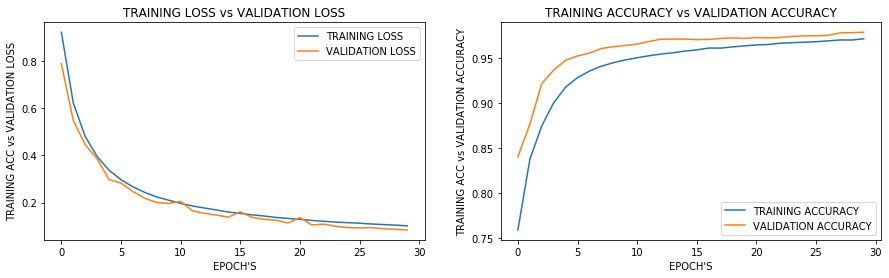

In [76]:
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1) 
plt.plot(history2.history['loss'], label = "TRAINING LOSS") 
plt.plot(history2.history['val_loss'], label = "VALIDATION LOSS") 
plt.title("TRAINING LOSS vs VALIDATION LOSS")
plt.xlabel("EPOCH'S") 
plt.ylabel("TRAINING ACC vs VALIDATION LOSS") 
plt.legend(loc = "best") 

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label = "TRAINING ACCURACY") 
plt.plot(history2.history['val_accuracy'], label = "VALIDATION ACCURACY") 
plt.title("TRAINING ACCURACY vs VALIDATION ACCURACY") 
plt.xlabel("EPOCH'S") 
plt.ylabel("TRAINING ACC vs VALIDATION ACCURACY") 
plt.legend(loc = "best") 

Explained in results section. 

In [77]:
from sklearn.tree import DecisionTreeClassifier
model3 = DecisionTreeClassifier()
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test) # prediksi

In [78]:
# Evaluasi Model menggunakan Confusion Matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))


array([[ 9277,     0,     4,     0,     0],
       [    1, 13367,     8,     2,     1],
       [    2,     6,  2325,     0,     0],
       [    0,     5,     0,   183,     1],
       [    0,     3,     1,     1,     8]], dtype=int64)

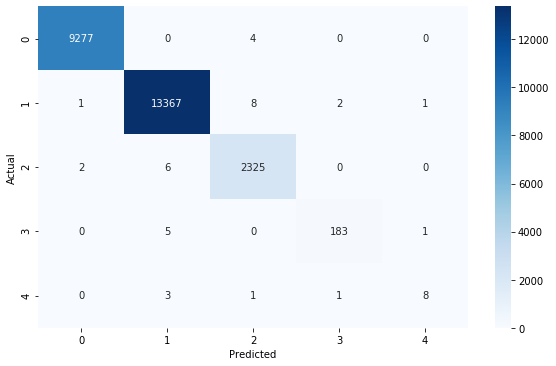

In [79]:
# memvisualisasikan confusion matrix 

# Install seabornhttp://localhost:8888/notebooks/Deep-Learning-Based-Intrusion-Detection-NSL-KDD/UAS_IDS%2BConfusion%20Matrix-Kumpulin.ipynb#
# !conda install -c anaconda seaborn -y 

import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax, cmap=plt.cm.Blues)
plt.tight_layout()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [80]:
# Dari confusion matrix kita dapat mengetahui keakuratan dari model yang dibuat
# dgn melihat performance metrics seperti: accuracy, recall, dan precision

from sklearn.metrics import classification_report
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9281
           1       1.00      1.00      1.00     13379
           2       0.99      1.00      1.00      2333
           3       0.98      0.97      0.98       189
           4       0.80      0.62      0.70        13

   micro avg       1.00      1.00      1.00     25195
   macro avg       0.96      0.92      0.93     25195
weighted avg       1.00      1.00      1.00     25195
 samples avg       1.00      1.00      1.00     25195

